# Zero inflated Poisson

In [8]:
import sys
sys.path.append('D:/source/repos')
from utilities.std_imports import *
import statsmodels.discrete.count_model as cm
import math as math
import scipy.stats as ss

## Example 1

### Generate data

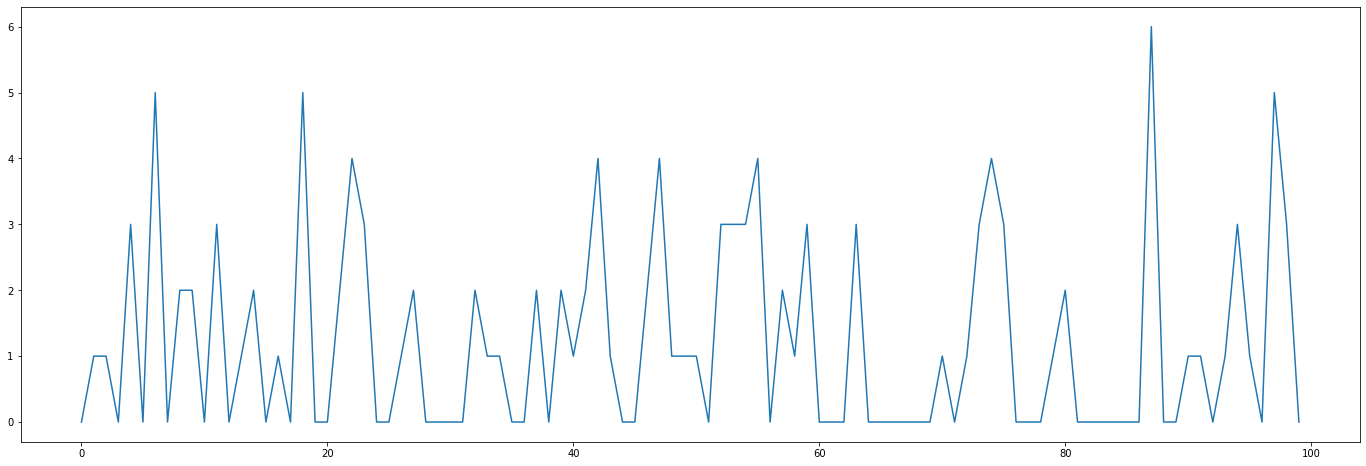

In [3]:
n = 100000
x0 = np.random.normal(6, 1, size=n)
x1 = np.random.normal(6, 1, size=n)
x = np.stack([x0, x1]).T
pois = np.zeros(n)
zinf = np.zeros(n)

pois_params = np.array([0.2, -0.1])
zinf_params = np.array([0.3, -0.2])

pois = np.random.poisson(np.exp(x @ pois_params))
zinf = np.random.logistic(x @ zinf_params) > 0

y = pois * zinf
plt.figure(figsize=(24,8))
plt.plot(y[:100]);
plt.show()

### Train model

In [4]:
mask = np.random.rand(n) <= 0.7
x_train = x[mask]
y_train = y[mask]
x_test = x[~mask]
y_test = y[~mask]

out = cm.ZeroInflatedPoisson(y_train, x_train, exog_infl=x_train)
res = out.fit()
res.summary()

D:\ProgramFiles\Python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 1.464829
         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                69861
Model:             ZeroInflatedPoisson   Df Residuals:                    69859
Method:                            MLE   Df Model:                            1
Date:                 Sun, 28 Mar 2021   Pseudo R-squ.:                 0.02869
Time:                         16:52:56   Log-Likelihood:            -1.0233e+05
converged:                        True   LL-Null:                   -1.0536e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
inflate_x1    -0.2942      0.007    -40.375      0.000      -0.308      -0.280
inflate_x2     0.1954      0.007     26.874      0.000       0.181       0.210
x1             0.2015      0.003     76.230      0.000       0.196       0.207
x2            -0.1011      0.003    -35.089      0.000      -0.107      -0.095
==============================================================================
"""

### Predict

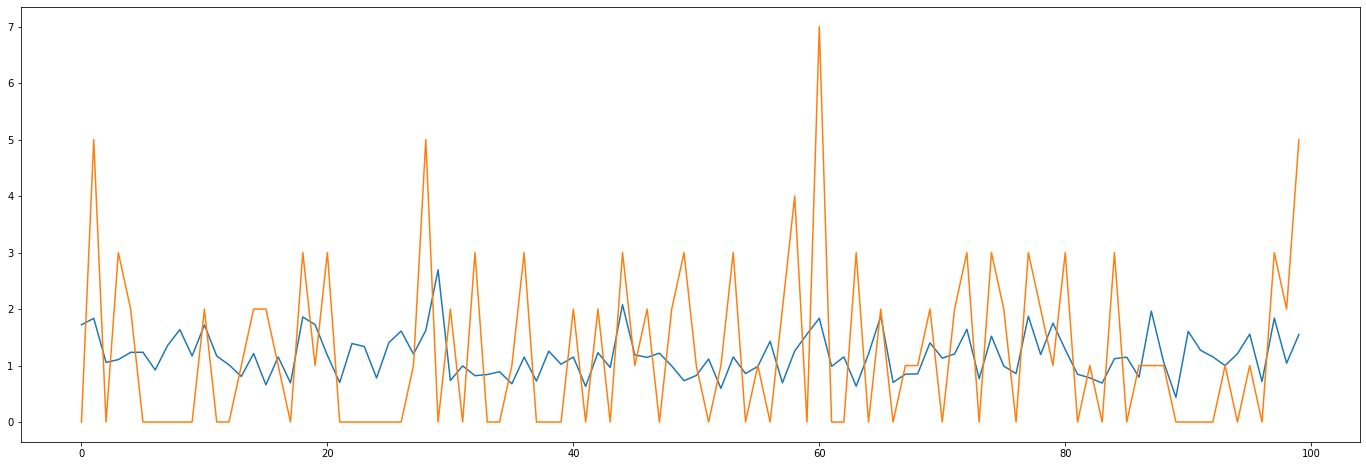

In [5]:
pred = res.predict(x_test, exog_infl=x_test, which='mean')
plt.figure(figsize=(24,8))
plt.plot(pred[:100]);
plt.plot(y_test[:100])
plt.show();

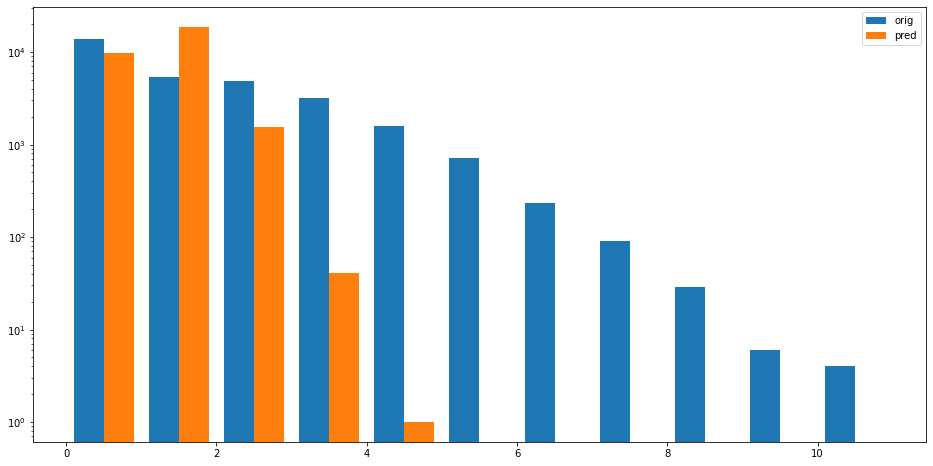

In [6]:
plt.figure(figsize=(16,8))
plt.hist([y_test, pred], log=True, bins=max(y_test))
plt.legend(('orig','pred'));

### Example 2

### Generate data

In [33]:
np.random.seed(123456789)
m = 5
sd = 1 
N = 100000
x1= np.random.normal(m,sd,size=N)
x2= np.random.normal(m,sd,size=N)
x = pd.DataFrame({'x1':x1, 'x2':x2})
x.head()

,x1,x2
0,7.212902,5.344758
1,7.128398,4.654915
2,6.841711,4.715646
3,5.082382,5.770086
4,5.858964,3.736356


#### Poisson

$\large \lambda = e^{\beta X} \Rightarrow \ln \lambda = \beta X $

In [42]:
poisson = np.zeros(N)
poi_beta = [0.2, -0.1]
for i, item in enumerate(x1):
    bXi = poi_beta[0] * x1[i] + poi_beta[1] * x2[i]
    lmbda = math.exp(bXi)
    poisson[i] = np.random.poisson(lmbda) 
    
print('Poisson: \t', poisson[0:20])

Poisson: 	 [0. 3. 4. 0. 2. 0. 2. 2. 2. 3. 1. 1. 1. 2. 2. 1. 2. 2. 1. 2.]


#### Zero inflated

In [51]:
zeroinf = np.zeros(N)
zinf_beta = [0.3, -0.2]
for i, item in enumerate(x1):   
    bXi = zinf_beta[0] * x1[i] + zinf_beta[1] * x2[i]
    zeroinf[i] = np.random.logistic(-bXi) > 0 

print('Zero inflated: \t', zeroinf[0:20,])

Zero inflated: 	 [1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.]


#### Zero inflated poisson

In [52]:
y = poisson * zeroinf
print('Zero inflated poisson: \t', y[0:20,])

Zero inflated poisson: 	 [0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 0. 2. 1. 2.]


### Fit the model

In [53]:
model = cm.ZeroInflatedPoisson(endog=y, exog=x, exog_infl=x, inflation='logit')
model_fit = model.fit(method='bfgs', maxiter=1000)
model_fit.params

D:\ProgramFiles\Python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 1.005812
         Iterations: 11
         Function evaluations: 15
         Gradient evaluations: 15


inflate_x1    0.299397
inflate_x2   -0.199259
x1            0.195391
x2           -0.098185
dtype: float64

### Credits & Links

https://stats.stackexchange.com/questions/450355/predicted-counts-for-zero-inflated-poisson-model-differ-from-original-samples  
https://bryansweber.com/2018/10/26/python-and-zero-inflated-models/